# About this Notebook

The purpose of this notebook is to show the different steps of possible corrections on the data and the Tolles-Lawson compensation method

# Table of content

# Setup

In [1]:
# Insert path for magnav module
import sys
sys.path.insert(0,'../src')

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from anomaly_maps import ChallMagMap
import magnav
import ppigrf
from scipy import signal
import numpy as np
import ipywidgets as widgets
from tabulate import tabulate
import datetime

# 0 - Import Data

## 0.1 - Flight data

In [3]:
df1002 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1002')
df1003 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1003')
df1004 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1004')
df1005 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1005')
df1006 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1006')
df1007 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1007')

In [4]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5), ('1006', 6), ('1007', 7)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5),…

In [5]:
df_sel_flight = eval(f'df100{w_flight.value}')

## 0.2 - Map data

In [6]:
# Load anomaly maps

EasternMap = ChallMagMap('../data/raw/Eastern_2.h5')
RenfrewMap = ChallMagMap('../data/raw/Renfrew_2.h5')
GscMap     = ChallMagMap('../data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = ChallMagMap('../data/external/map_WDMAM.hdf5')

# 1 - Tolles-Lawson

## 1.1 - What is Tolles-Lawson ?

Tolles-Lawson uses measurements from a vector magnetometer to remove aircraft magnetic field contributions to the scalar magnetometer measurements, which are used for navigation. It is anticipated that the magnetic dynamics of an operational aircraft will exceed this model, but its assumptions are valid for compensation of the the stinger magnetometer. The Tolles-Lawson procedure considers the projection of the aircraft magnetic field onto the earth magnetic field, whereas a slightly modified version in Han_2017 considers the projection of the aircraft magnetic field onto the total field, which follows here

![coordinate_system](../data/external/Images/coordinate_system.JPG)

(a)Earth, aircraft, and total magnetic field vectors with projections of the aircraft and earth magnetic fields onto the total magnetic field. (b) Aircraft coordinate system centered on the front seat rail, where $x$ is positive in the aircraft forward direction, $y$ is positive to port (left facing forward), and $z$ is positive upward.

The total magnetic field vector $\mathbf H_t = \mathbf H_e + \mathbf H_a$ is comprised of the earth $\mathbf H_e$ and aircraft $\mathbf H_a$ fields. The reference frame is defined with respect to the transverse, longitudinal, and vertical axes of the aircraft, as shown in Figure. The aircraft magnetic field includes contributions from the permanent magnetic moment, induced magnetic moment, and eddy currents of the aircraft. Their contributions to the magnitude of the total field can be written as Eq.1 :
\begin{equation} \label{eq:H_at} H_{at} = \mathbf P \mathbf u_t + \mathbf u_t^T A \mathbf u_t + (\mathbf u_t^T)' \mathbf B \mathbf u_t \end{equation}

where the unit vector
\begin{equation} \mathbf u_t = \frac{\mathbf H_t}{H_t} = \begin{pmatrix} \cos X \\ \cos Y \\ \cos Z \\ \end{pmatrix} \end{equation}

is directly measured by the vector magnetometer, and consists of direction cosines defined by angles $X, Y, Z$ between the total field vector and the respective axes of the reference frame. The coefficient matrices for the permanent moment
\begin{equation} \mathbf P = \begin{pmatrix} p_1 & p_2 & p_3 \end{pmatrix} \end{equation}

induced moment
\begin{equation} \mathbf A = \begin{pmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{pmatrix} \end{equation}

and eddy current
\begin{equation} \mathbf B = \begin{pmatrix} b_{11} & b_{12} & b_{13} \\ b_{21} & b_{22} & b_{23} \\ b_{31} & b_{32} & b_{33} \end{pmatrix} \end{equation}

contributions comprise the unknown coefficients to learn during calibration.

Consider the physics underlying this construction. The permanent dipole moment and resulting magnetic field of the aircraft are static with respect to the coordinate system, with projections onto the total field defined by the direction cosines. From this, it can be seen that $\mathbf P$ is the magnetic field vector due to the permanent dipole, with components along the reference frame axes. Note that the numerical indices (1, 2, 3) coincide with the corresponding ($x$, $y$, $z$) axes.

The induced dipole moment can be thought of as resulting from three bars which can be magnetized along the $x$, $y$, and $z$ axes, with moments proportional to the earth magnetic field projection onto that axis, but not necessarily located on any axis. In general, each dipole will create a vector field at the origin. This means $\mathbf A$ has components $a_{ij}$, where $u_i a_{ij}$ gives the component of the induced field in the $j$ direction due to the moment pointing in the $i$ direction.

A similar argument holds for the geometry and projections of the eddy current fields comprising $\mathbf B$. The notable difference is that the eddy currents arise from changes in the magnetic flux through surfaces of the aircraft, which make their contribution proportional to the time derivative of the direction cosines $(\mathbf u_t^T)'$.

The quadratic form of the second term in Eq. 1 implies that $\mathbf A$ can be made symmetric, reducing the number of unknown coefficients for the induced dipole field from 9 to 6, resulting in 18 Tolles-Lawson coefficients. Additional constraints, such as the direction cosine identity $\cos^2 X + \cos^2 Y + \cos^2 Z = 1$ or assumptions about the surfaces of the aircraft, may further reduce the number of terms and coefficients used in the Tolles-Lawson model.

**Tolles-Lawson Calibration**

Here a linear model is built to determine the unknown Tolles-Lawson coefficients.

A row vector of measurements is
\begin{equation} \boldsymbol \delta = \begin{pmatrix} \{u_i\} & \{u_i u_j\} & \{u_i' u_j\}\end{pmatrix} \end{equation}

at a given time step, and a matrix of these is measurements is
\begin{equation} \boldsymbol \Delta = \begin{pmatrix} \boldsymbol \delta_1 \\ \vdots \\ \boldsymbol \delta_{N_t}\end{pmatrix} \end{equation}

where each row is one of the $N_t$ timesteps and each column is a term $\cos X$, $\cos Y$, etc. The column vector of coefficients is \begin{equation} \boldsymbol \theta = \begin{pmatrix} \{p_i\} & \{a_{ij}\} & \{b_{ij}\}\end{pmatrix} \end{equation}

Because the magnitude of the total field $H_t = H_{at} + H_{et}$ is the sum of the projections of the aircraft and earth magnetic field onto the total magnetic field, the $N_t \times 1$ column vector $\mathbf h_t$ of total field measurements $H_t$ from the scalar magnetometer can be expressed as (Eq. 2) \begin{equation} \label{eq:H_TL} \mathbf H = \boldsymbol \Delta \boldsymbol \theta + \mathbf H_{et} \end{equation}

where $\mathbf h_{et}$ is the column vector of $H_{et}$ at each timestep, which cannot be measured directly.

To decouple the aircraft field from the earth field, it is helpful to identify a band in which the frequency content of the aircraft dominates the signal. The calibration flight pattern is roughly a square or a cloverleaf, with roll, pitch and yaw maneuvers performed along each leg. It can be helpful to think of these maneuvers as injecting aircraft magnetic field content into a given band. The square pattern is repeated in opposite directions, and is flown at high altitude with as tight turns as possible. While the frequency band of interest for magnetic navigation is between 1 mHz and 1 Hz, a **band of 0.1 - 0.9 Hz is typically used for calibration**. Applying a bandpass filter both sides of Eq.2 gives 
\begin{equation}
    bpf(\mathbf H) = bpf(\boldsymbol \Delta) \boldsymbol \theta + bpf(\mathbf H_{et}).
\end{equation}
If the bandpass-filtered earth magnetic field projection is zero, i.e. $bpf(\mathbf H_{et}) = 0$, 
\begin{equation}
    \mathbf y = \mathbf D \boldsymbol \theta
\end{equation}
where $\mathbf y = bpf(\mathbf H_t)$ and $\mathbf D = bpf(\boldsymbol \Delta)$.

## 1.2 - Compensation maneuvers

To perform a Tolles Lawson type compensation, we need a flight pattern over a magnetic plain (with few disturbances) with high amplitude aircraft movements. This is to highlight the impact of the aircraft on the magnetic measurements and these data are then enetred into the model to serve as a reference for the correction. We have two pattern available :
- A square pattern
- A cloverleaf pattern

In [7]:
flight_number = 2

mask_1 = (df1002.LINE == 1002.02)
mask_2 = (df1002.LINE == 1002.20)

tl_sq = df1002[mask_1] # Square Tolles-Lawson pattern
tl_cl = df1002[mask_2] # Cloverleaf Tolles-Lawson pattern

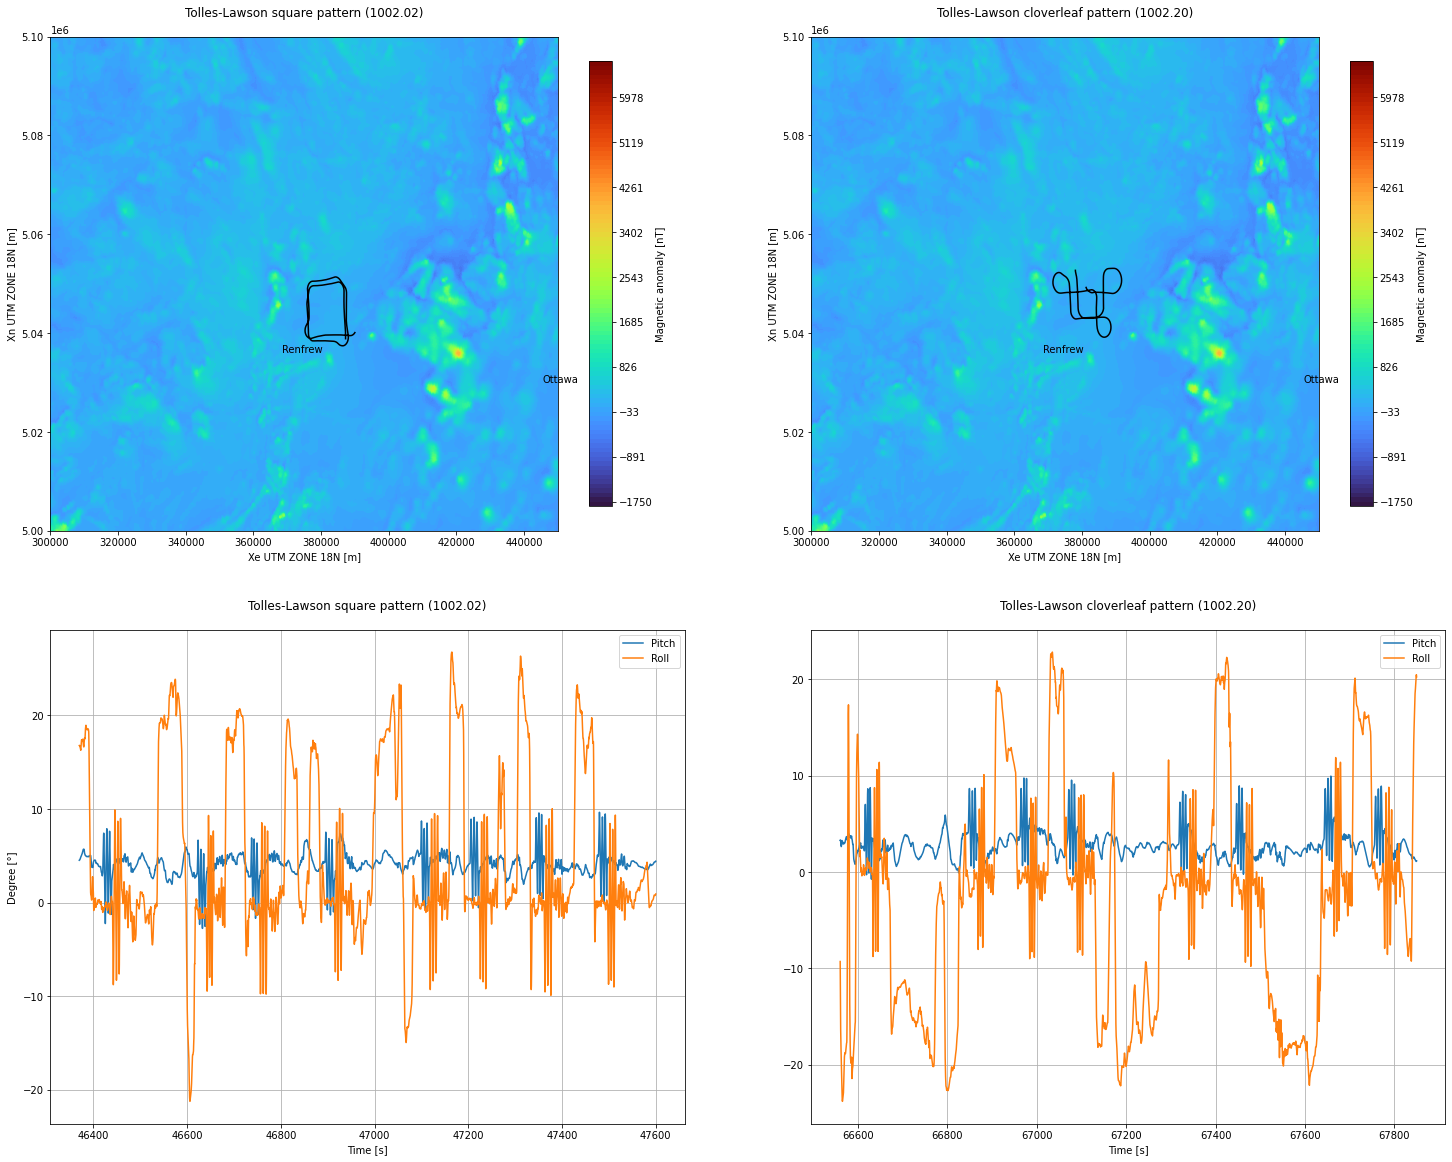

In [8]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,sharex=False,sharey=False,figsize=[25,20])

tl_sq.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = GscMap.plot(ax1,plot_city=True)
ax1.set_title('Tolles-Lawson square pattern (1002.02)',pad=20);
ax1.set_xlim(3e5, 4.5e5)
ax1.set_ylim(5e6, 5.1e6);

tl_cl.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = GscMap.plot(ax2, plot_city=True)
ax2.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20);
ax2.set_xlim(3e5, 4.5e5)
ax2.set_ylim(5e6, 5.1e6);

ax3.plot(tl_sq[['PITCH','ROLL']])
ax3.set_title('Tolles-Lawson square pattern (1002.02)',pad=20)
ax3.legend(['Pitch','Roll'])
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Degree [°]')
ax3.grid()

ax4.plot(tl_cl[['PITCH','ROLL']])
ax4.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20)
ax4.legend(['Pitch','Roll'])
ax4.set_xlabel('Time [s]')
ax4.grid()

plt.show()

## 1.3 - Band pass filters

As said before, we use a bandpass filter to extract the frequency band where magnetic effects of the aircraft dominates the signal. In our case we use 2 types of filters, a Butterworth filter and a finite impulse response filter. The difference between the two filters on our data is almost insignificant.

low cut = 0.1 Hz, High cut = 0.9 Hz, sampling frequency = 10 Hz

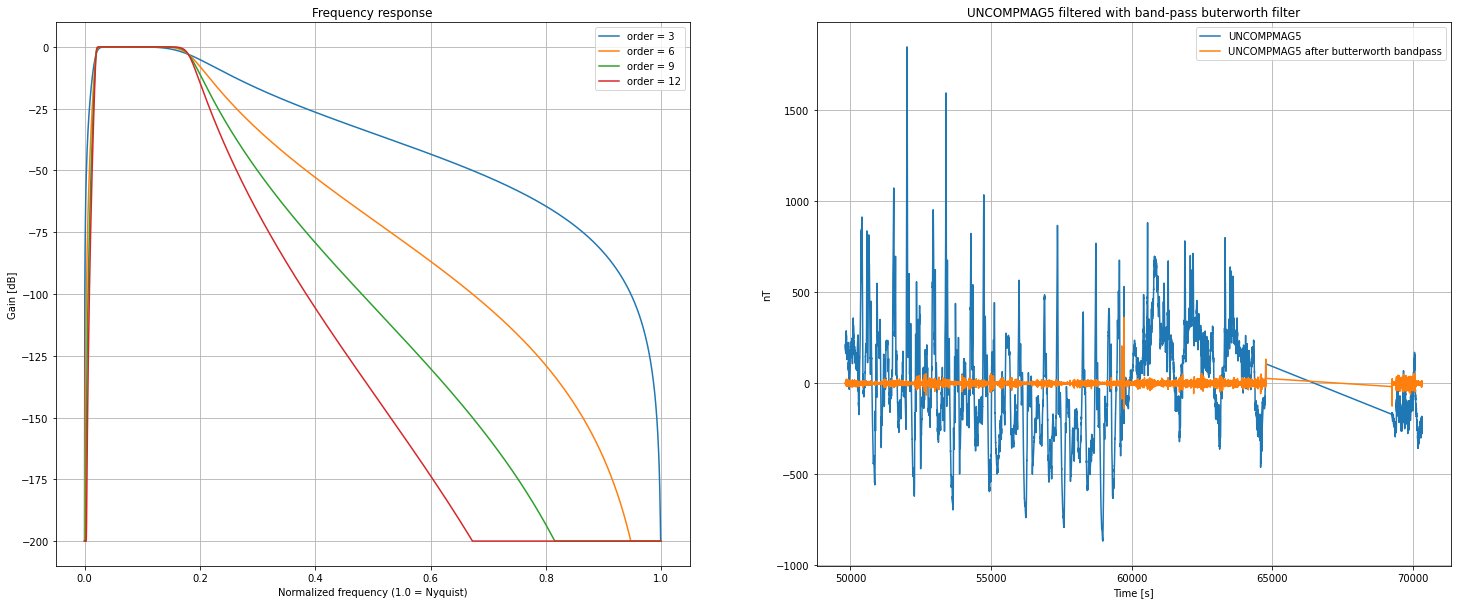

In [9]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9

fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for order in [3,6,9,12]:
    sos  = magnav.create_butter_filter(lowcut,highcut,fs,order=order)
    w, h = signal.sosfreqz(sos,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'order = {order}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.legend()
ax1.grid()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_butter_filter(sig,lowcut,highcut,fs,order=4)
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after butterworth bandpass')

ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with band-pass buterworth filter')

plt.show()

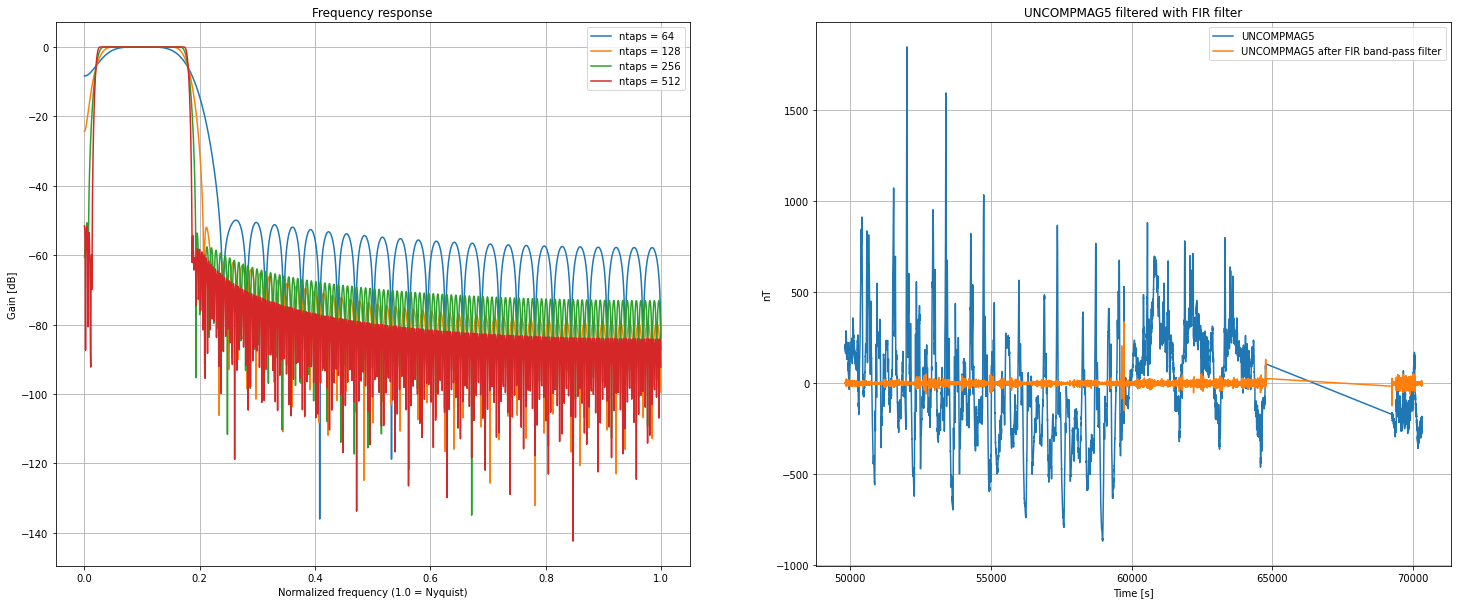

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for ntaps in [64,128,256,512]:
    taps_hamming = magnav.create_firwin_filter(lowcut,highcut,fs,ntaps)
    w, h = signal.freqz(taps_hamming,1,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'ntaps = {ntaps}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.grid()
ax1.legend()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_firwin_filter(sig,lowcut,highcut,fs,ntaps=255,window='hamming')
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after FIR band-pass filter')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with FIR filter')

plt.show()

## 1.4 - Tolles-Lawson coefficients | Square pattern

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a square pattern.

In [11]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG1'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG2'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG3'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG4'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG5'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sq'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sq'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sq'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sq'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sq'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

## 1.5 - Tolles Lawson coefficients | Cloverleaf pattern <a class="anchor" id = "5.1.5"></a>

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a cloverleaf pattern.

In [12]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG1'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG2'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG3'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG4'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG5'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_cl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_cl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_cl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_cl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_cl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

## 1.6 - Tolles Lawson coefficients | Square+Cloverleaf pattern <a class="anchor" id = "5.1.6"></a>

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a mix between square and cloverleaf pattern. This is an experimental test to see if we can take advantage of the two different patterns.

In [13]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Combine SQ and CL patterns
tl_sqcl = df1002[mask_1+mask_2]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG1'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG2'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG3'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG4'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG5'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

## 1.7 - Comparison between maneuvrers

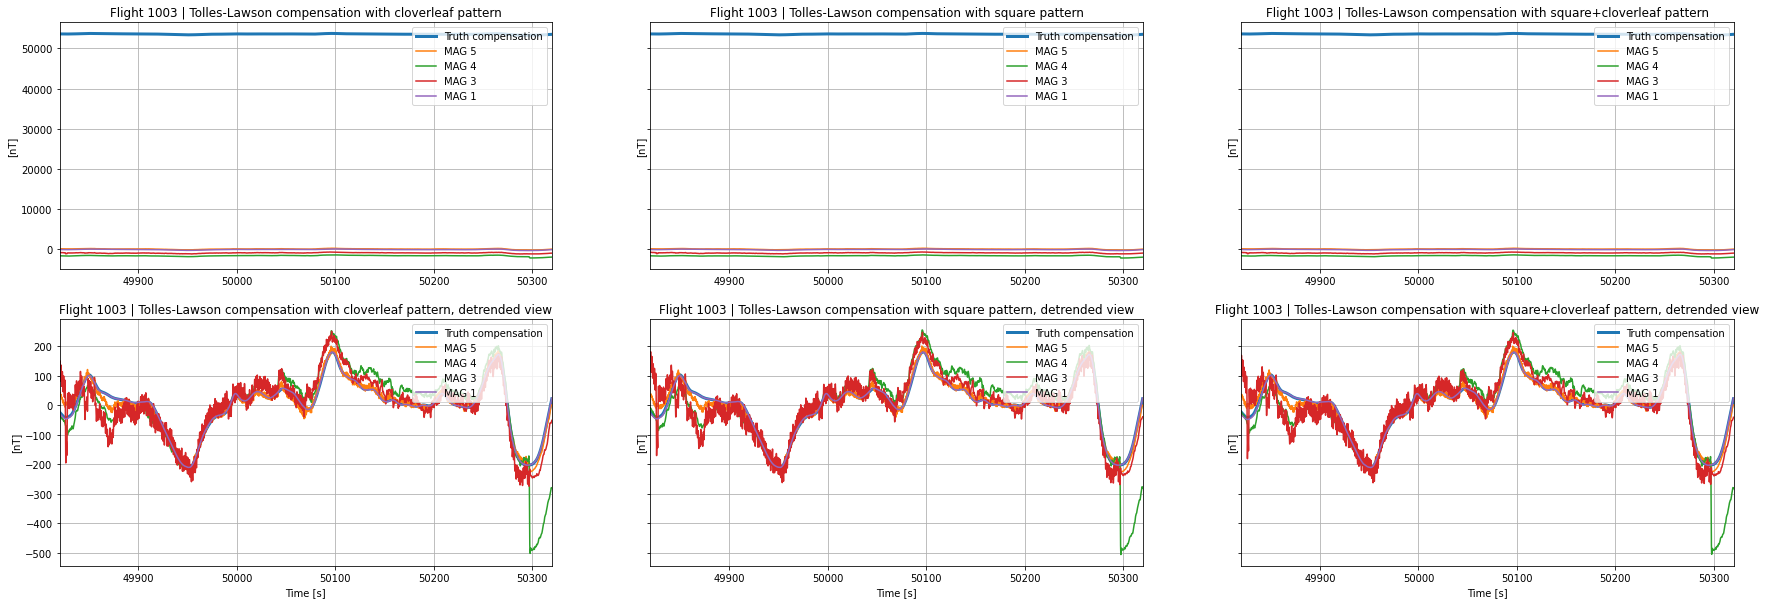

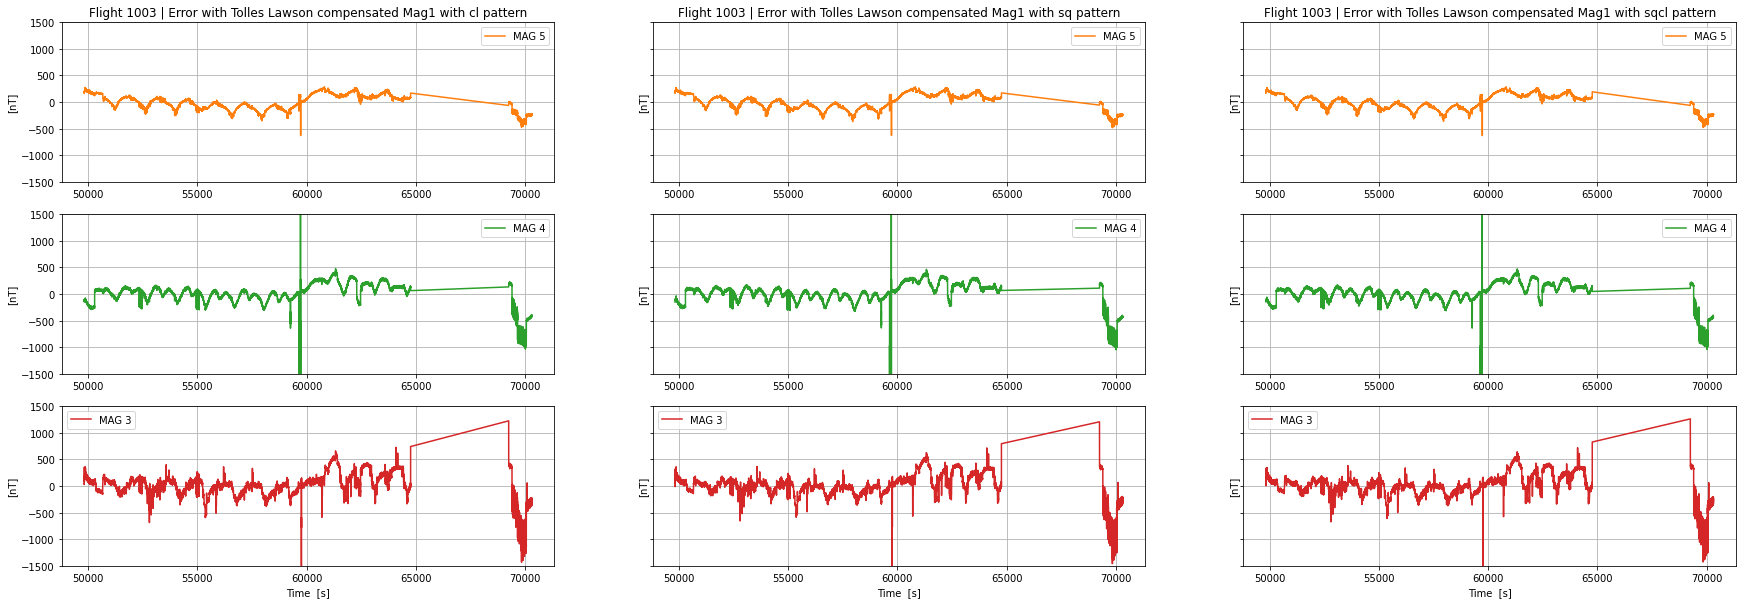


RMSE between Tolles Lowson compensated magnetometers and truth compensation (SGL COMPMAG1) :
╒════════════════╤════════════════════════════════════╤════════════════════════════════╤═══════════════════════════════════════════╕
│   Magnetometer │   Cloverleaf compensation RMSE[nT] │   Square compensation RMSE[nT] │   Cloverleaf+Square compensation RMSE[nT] │
╞════════════════╪════════════════════════════════════╪════════════════════════════════╪═══════════════════════════════════════════╡
│          Mag 1 │                          169.69 nT │                      169.68 nT │                                 170.08 nT │
├────────────────┼────────────────────────────────────┼────────────────────────────────┼───────────────────────────────────────────┤
│          Mag 2 │                        18994.77 nT │                    12040.35 nT │                               15455.22 nT │
├────────────────┼────────────────────────────────────┼────────────────────────────────┼────────────────────

In [25]:
fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize=[30,10],sharey='row')

# Cloverleaf pattern
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_cl'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_cl'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_cl'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_cl'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax1.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax4.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('[nT]')
ax4.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern, detrended view')
ax4.legend(loc='upper right')
ax4.grid()

# Square pattern
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_sq'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_sq'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_sq'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_sq'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax2.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax5.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('[nT]')
ax5.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern, detrended view')
ax5.legend(loc='upper right')
ax5.grid()

# Square+Cloverleaf pattern
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax3.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax6.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('[nT]')
ax6.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern, detrended view')
ax6.legend(loc='upper right')
ax6.grid()

plt.show()

fig, ([ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]) = plt.subplots(3,3,figsize=[30,10],sharey=True)

ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_cl'])),'C1',label='MAG 5')
ax4.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_cl'])),'C2',label='MAG 4')
ax7.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_cl'])),'C3',label='MAG 3')

ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sq'])),'C1',label='MAG 5')
ax5.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sq'])),'C2',label='MAG 4')
ax8.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sq'])),'C3',label='MAG 3')

ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sqcl'])),'C1',label='MAG 5')
ax6.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sqcl'])),'C2',label='MAG 4')
ax9.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sqcl'])),'C3',label='MAG 3')

ax1.set_ylim([-1500,1500])
ax1.grid(),ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid(),ax6.grid(),ax7.grid(),ax8.grid(),ax9.grid()
ax1.legend(),ax2.legend(),ax3.legend(),ax4.legend(),ax5.legend(),ax6.legend(),ax7.legend(),ax8.legend(),ax9.legend()
ax7.set_xlabel('Time  [s]'),ax8.set_xlabel('Time  [s]'),ax9.set_xlabel('Time  [s]')
ax1.set_ylabel('[nT]'),ax2.set_ylabel('[nT]'),ax3.set_ylabel('[nT]'),ax4.set_ylabel('[nT]'),ax5.set_ylabel('[nT]'),ax6.set_ylabel('[nT]'),ax7.set_ylabel('[nT]'),ax8.set_ylabel('[nT]'),ax9.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with cl pattern')
ax2.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sq pattern')
ax3.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sqcl pattern')
plt.show()


RMSE_mag1_sq = magnav.rmse(df_sel_flight['TL_comp_mag1_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag2_sq = magnav.rmse(df_sel_flight['TL_comp_mag2_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag3_sq = magnav.rmse(df_sel_flight['TL_comp_mag3_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag4_sq = magnav.rmse(df_sel_flight['TL_comp_mag4_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag5_sq = magnav.rmse(df_sel_flight['TL_comp_mag5_sq'],df_sel_flight['COMPMAG1'])

RMSE_mag1_cl = magnav.rmse(df_sel_flight['TL_comp_mag1_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag2_cl = magnav.rmse(df_sel_flight['TL_comp_mag2_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag3_cl = magnav.rmse(df_sel_flight['TL_comp_mag3_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag4_cl = magnav.rmse(df_sel_flight['TL_comp_mag4_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag5_cl = magnav.rmse(df_sel_flight['TL_comp_mag5_cl'],df_sel_flight['COMPMAG1'])

RMSE_mag1_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag1_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag2_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag2_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag3_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag3_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag4_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag4_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag5_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag5_sqcl'],df_sel_flight['COMPMAG1'])

table = [['Magnetometer','Cloverleaf compensation RMSE[nT]','Square compensation RMSE[nT]','Cloverleaf+Square compensation RMSE[nT]'],
         ['Mag 1',f'{RMSE_mag1_cl:.2f} nT',f'{RMSE_mag1_sq:.2f} nT',f'{RMSE_mag1_sqcl:.2f} nT'],
         ['Mag 2',f'{RMSE_mag2_cl:.2f} nT',f'{RMSE_mag2_sq:.2f} nT',f'{RMSE_mag2_sqcl:.2f} nT'],
         ['Mag 3',f'{RMSE_mag3_cl:.2f} nT',f'{RMSE_mag3_sq:.2f} nT',f'{RMSE_mag3_sqcl:.2f} nT'],
         ['Mag 4',f'{RMSE_mag4_cl:.2f} nT',f'{RMSE_mag4_sq:.2f} nT',f'{RMSE_mag4_sqcl:.2f} nT'],
         ['Mag 5',f'{RMSE_mag5_cl:.2f} nT',f'{RMSE_mag5_sq:.2f} nT',f'{RMSE_mag5_sqcl:.2f} nT']]

print('\nRMSE between Tolles Lowson compensated magnetometers and truth compensation (SGL COMPMAG1) :')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='right'))

<font size="4">Interpretation of results :</font><br> <a class="anchor" id = "explication"></a>
The magnetometer compensation matches the compensation made by SGL which corresponds to the truth (as can be seen for the magnetometer 1). However these data do not yet correspond to the magnetic anomaly measurements (truth in our case). For this we still have some corrections to make. The magnetometer 2 has very bad results. Magnetometer 5 is close to magnetometer 1. We also have the visualization of the error between the magnetometers and the truth, we see on this one that the error seems to be cyclic in the case of flight 1003. This is due to the overlapping pattern of the flight. We also observe a peak of error around 59700 seconds for flight 1003. This peak is due to a change in topology, and as SGL has smoothed its sensor, we get an error peak at this location. You can see it below in the topography of the flight.

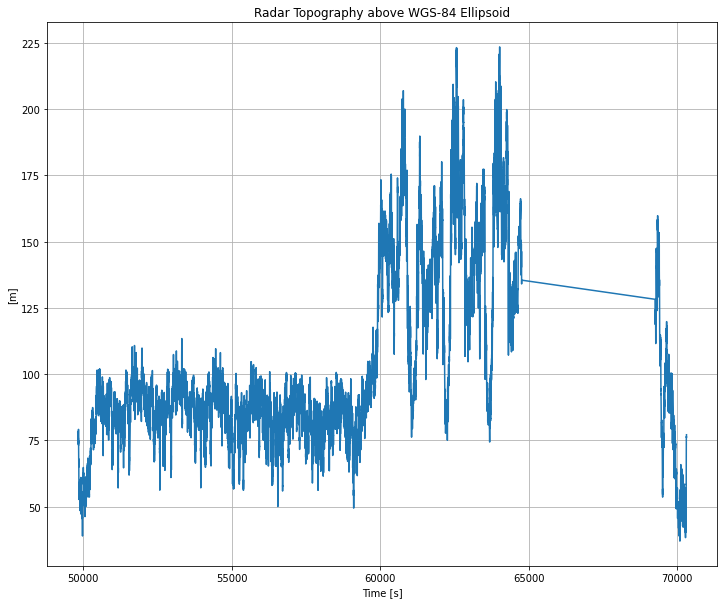

In [15]:
fig, ax = plt.subplots(figsize=[12,10])
ax.plot(df1003['TOPO'])
ax.grid(),ax.set_title('Radar Topography above WGS-84 Ellipsoid'),ax.set_ylabel('[m]'),ax.set_xlabel('Time [s]')
plt.show()

# 2 - Corrections

## 2.1 - Lag correction

The lag is the response of a measuring instrument to a change in the measured quantity. It is a retardation delay in the response of a measurement system to changes in the measured quantity. In our case, we can calculate the lag as follows :<br><br>
<font size="3">
    $Lag = \frac{sensor\;offset}{aircraft\;speed}$
</font><br><br>
sensor offset  : distance between reference point (front seat rail) and the sensor in meters<br>
aircraft speed : speed of the aircraft at which the measurement was made in meters per second<br>

In our case we can approximate the lag over the whole flight because the speed of the aircraft is almost constant.

In [16]:
Lag_mag1 = 12.01/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag2 = 0.60/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag3 = 1.28/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag4 = 3.53/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag5 = 3.79/np.mean(df_sel_flight['TRUE_AS'])

table = [['Magnetometer','Lag'],
         ['Mag 1',f'{Lag_mag1:.2f} s'],
         ['Mag 2',f'{Lag_mag2:.2f} s'],
         ['Mag 3',f'{Lag_mag3:.2f} s'],
         ['Mag 4',f'{Lag_mag4:.2f} s'],
         ['Mag 5',f'{Lag_mag5:.2f} s']]

print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='center'))

╒════════════════╤════════╕
│  Magnetometer  │  Lag   │
╞════════════════╪════════╡
│     Mag 1      │ 0.18 s │
├────────────────┼────────┤
│     Mag 2      │ 0.01 s │
├────────────────┼────────┤
│     Mag 3      │ 0.02 s │
├────────────────┼────────┤
│     Mag 4      │ 0.05 s │
├────────────────┼────────┤
│     Mag 5      │ 0.06 s │
╘════════════════╧════════╛


<font size="4">Interpretation of results :</font><br>
Only the magnetometer 1 has a significant lag and is the only one we can correct by rounding the lag to 0,2s. If we want to be able to correct the other magnetometers, we need a higher sampling frequency of about 100Hz.

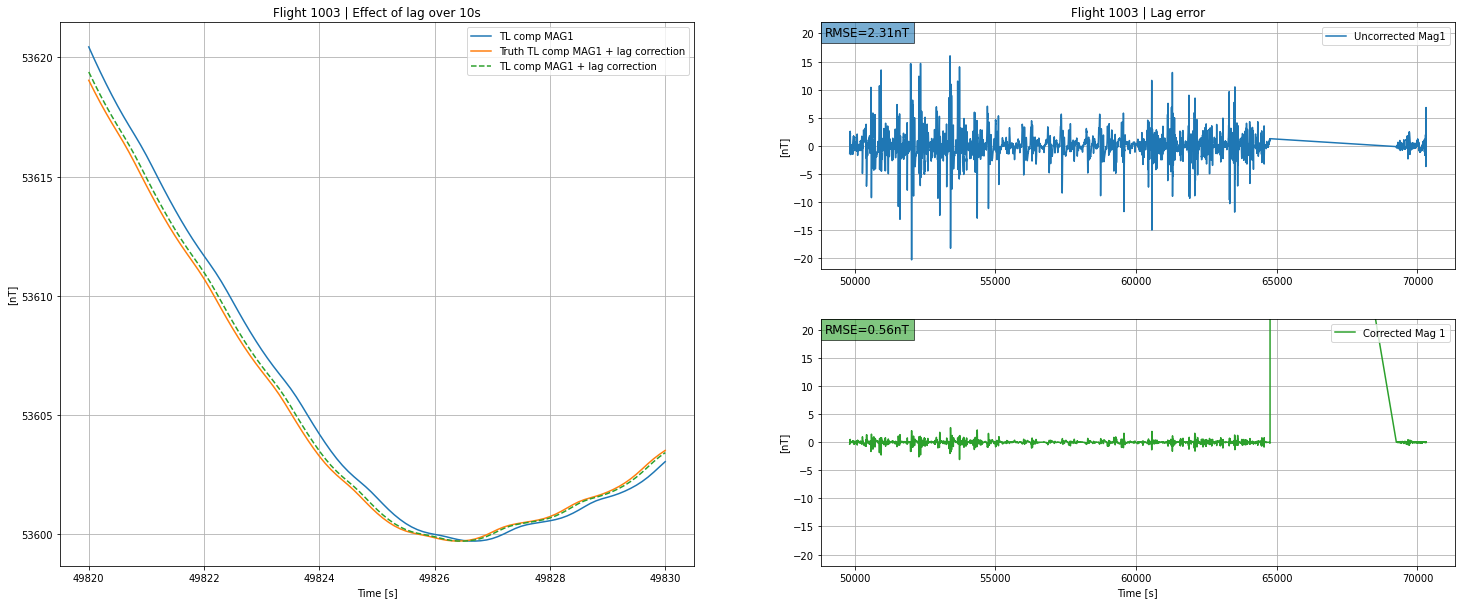

In [17]:
our_lag_cor       = df_sel_flight['COMPMAG1'].drop([df_sel_flight.index[0],df_sel_flight.index[1]])
our_lag_cor.index = df_sel_flight.index[:-2]
UNLAG_df = df_sel_flight.drop([df_sel_flight.index[-1],df_sel_flight.index[-2]])

plt.figure(figsize=[25,10])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,4)

ax1.plot(UNLAG_df[['COMPMAG1','LAGMAG1']][:df_sel_flight.index[0]+10])
ax1.plot(our_lag_cor[:df_sel_flight.index[0]+10],'--')
ax1.legend(['TL comp MAG1','Truth TL comp MAG1 + lag correction','TL comp MAG1 + lag correction'])
ax1.set_title(f'Flight 100{w_flight.value} | Effect of lag over 10s')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

ax2.plot(UNLAG_df['LAGMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax2.legend(['Uncorrected Mag1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag error')
ax2.set_ylabel('[nT]')
ax2.axes.set_ylim(-22,22)
ax2.grid()

lag_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['LAGMAG1'])
ax2.text(df_sel_flight.index[0]-870,19.5,f'RMSE={lag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax3.plot(UNLAG_df['LAGMAG1']-our_lag_cor,'C2')
ax3.legend(['Corrected Mag 1'],loc='upper right')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.axes.set_ylim(-22,22)
ax3.grid()

unlag_rmse = magnav.rmse(our_lag_cor,UNLAG_df['LAGMAG1'])
ax3.text(df_sel_flight.index[0]-870,19.5,f'RMSE={unlag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size="4">Interpretation of results :</font><br>
There is still a little error due to lag approximation. Also the truth lag correction was done with a professional software. Lag correction is not constant because it depends on aircraft speed and we assume that its constant but its not. The error is still small enough not to be considered as insignificant for the future.

## 2.2 - Diurnal correction

Also called **Solar Quiet currents (SQs)** or **Space Weather Effects**, the diurnal effects correspond to the different weather variations. This comes mainly from the ionization of the ionosphere by the sun creating a slight variation in ambient magnetic intensity. This includes different effects such as :
- Day and night cycle
- Aurora Borealis
- Solar stoms

These effects are measured by ground stations and thanks to these measurements, we can remove these effects from the data of the magnetometer.

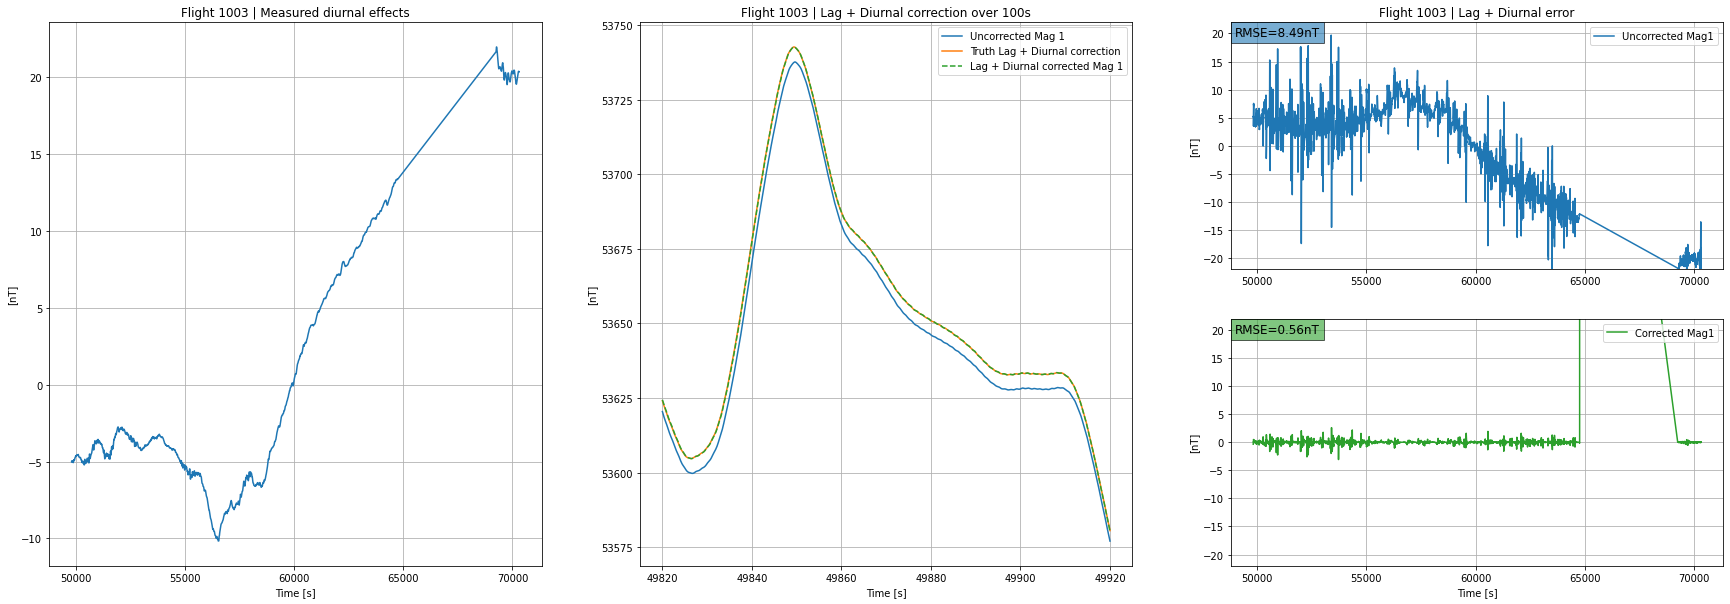

In [18]:
plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# Diurnal plot
ax1.plot(df_sel_flight['DIURNAL'])
ax1.set_title(f'Flight 100{w_flight.value} | Measured diurnal effects')
ax1.set_ylabel('[nT]')
ax1.set_xlabel('Time [s]')
ax1.grid()

# Diurnal correction
our_dc_cor = our_lag_cor-UNLAG_df['DIURNAL']

ax2.plot(UNLAG_df[['COMPMAG1','DCMAG1']].loc[:df_sel_flight.index[0]+100])
ax2.plot(our_dc_cor.loc[:df_sel_flight.index[0]+100],'--')
ax2.legend(['Uncorrected Mag 1','Truth Lag + Diurnal correction','Lag + Diurnal corrected Mag 1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal correction over 100s')
ax2.set_ylabel('[nT]')
ax2.set_xlabel('Time [s]')
ax2.grid()

# Diurnal errors
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['DCMAG1'])

ax3.plot(UNLAG_df['DCMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal error')
ax3.axes.set_ylim(-22,22)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(df_sel_flight.index[0]-830,19.5,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))


cor_rmse = magnav.rmse(our_dc_cor,UNLAG_df['DCMAG1'])

ax4.plot(df_sel_flight['DCMAG1']-our_dc_cor,'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-22,22)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(df_sel_flight.index[0]-830,19.5,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size="4">Interpretation of results :</font><br>
The error come from lag correction, we have the exact same diurnal correction as the truth.

## 2.3 - IGRF correction

The International Geomagnetic Reference Field (IGRF) is a set of spherical harmonic coefficients which can be input into a mathematical model in order to describe the large-scale, time-varying portion of Earth's internal magnetic field between epochs 1990 A.D. and the present. The model is regularly revised, typically every 5 years. The model varies little over time and is therefore ideal for navigation. The difference between the magnetometer measurements and the IGRF model corresponds to the magnetic anomalies.

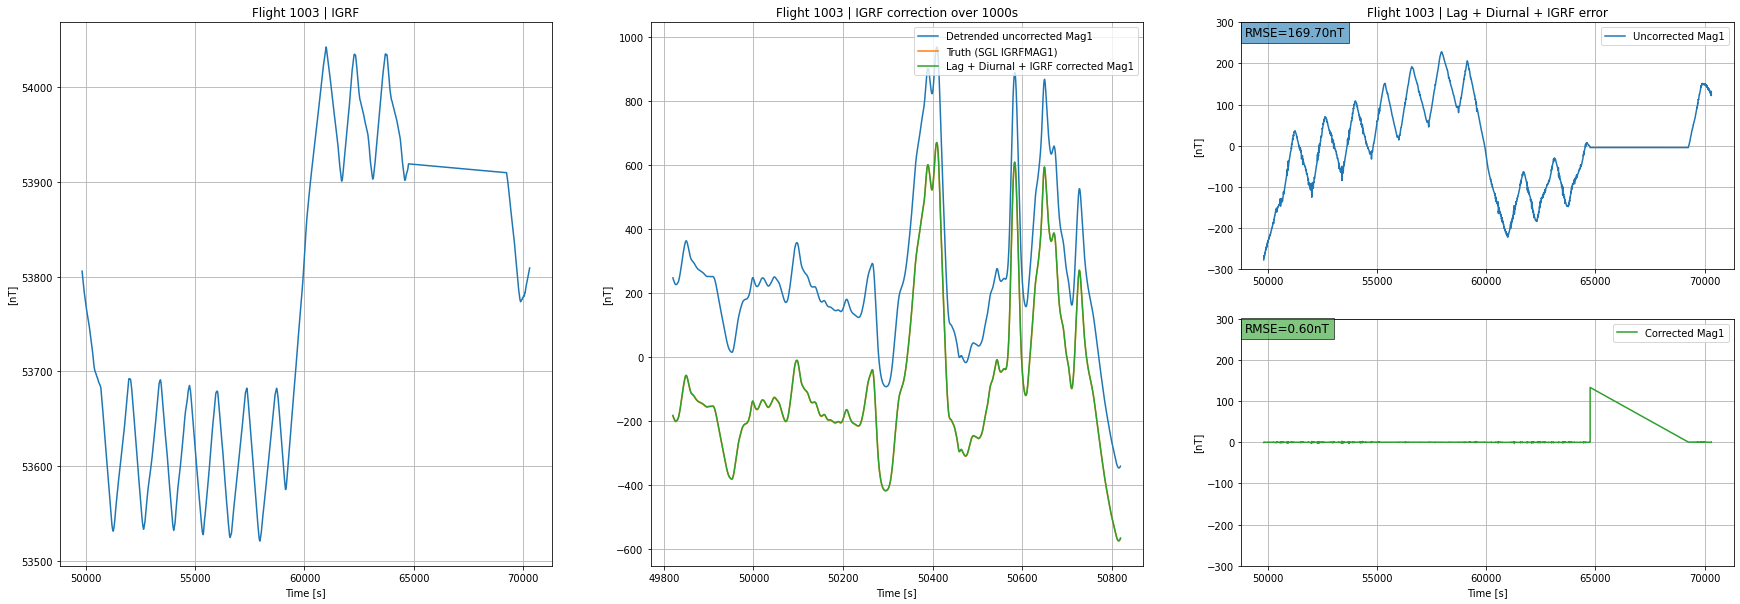

In [19]:
lat  = UNLAG_df['LAT']
lon  = UNLAG_df['LONG']
h    = UNLAG_df['BARO']*1e-3# kilometers above WGS84 ellipsoid, no impact on rmse due to low altitude
date = datetime.datetime(2020, 6, 29)

Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)

our_IGRF_cor = our_dc_cor - np.sqrt(Be**2+Bn**2+Bu**2)[0]

plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# IGRF offset
ax1.plot(UNLAG_df.index,np.sqrt(Be**2+Bn**2+Bu**2)[0])
ax1.set_title(f'Flight 100{w_flight.value} | IGRF')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

# IGRF correction
ax2.plot(UNLAG_df.index[:10000],signal.detrend(UNLAG_df['COMPMAG1'])[:10000])
ax2.plot(UNLAG_df['IGRFMAG1'][:UNLAG_df.index[0]+1000])
ax2.plot(our_IGRF_cor[:UNLAG_df.index[0]+1000])
ax2.legend(['Detrended uncorrected Mag1','Truth (SGL IGRFMAG1)','Lag + Diurnal + IGRF corrected Mag1'],loc='upper right')
ax2.set_title(f'Flight 100{w_flight.value} | IGRF correction over 1000s')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.grid()

# IGRF error
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['IGRFMAG1'])
cor_rmse = magnav.rmse(our_IGRF_cor,UNLAG_df['IGRFMAG1'])

ax3.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-UNLAG_df['COMPMAG1']),'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal + IGRF error')
ax3.axes.set_ylim(-300,300)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(UNLAG_df.index[0]-850,267,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax4.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-our_IGRF_cor),'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-300,300)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(UNLAG_df.index[0]-850,267,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))


plt.show()

## 2.4 - Tolles-Lawson + corrections

In [20]:
def apply_corrections(df,lag=True,diurnal=True,igrf=True):
    
    mag_measurements = np.array(['TL_comp_mag5_cl','TL_comp_mag4_cl','TL_comp_mag3_cl','TL_comp_mag2_cl','TL_comp_mag1_cl',
                        'TL_comp_mag5_sq','TL_comp_mag4_sq','TL_comp_mag3_sq','TL_comp_mag2_sq','TL_comp_mag1_sq',
                        'TL_comp_mag5_sqcl','TL_comp_mag4_sqcl','TL_comp_mag3_sqcl','TL_comp_mag2_sqcl','TL_comp_mag1_sqcl'])
    COR_df = df
    
    # Lag cor
    if lag == True:
        
        # 0.2s correction on mag1
        unlag = df[mag_measurements[[4,9,14]]].drop([df.index[0],df.index[1]])
        unlag.index = df.index[:-2]
        
        COR_df = df.drop([df.index[-1],df.index[-2]])
        COR_df = UNLAG_df.drop(columns=mag_measurements[[4,9,14]])
        COR_df[mag_measurements[[4,9,14]]] = unlag
    
    # Diurnal cor
    if diurnal == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(COR_df['DIURNAL'].values,[-1,1])
    
    # IGRF cor
    lat  = COR_df['LAT']
    lon  = COR_df['LONG']
    h    = COR_df['BARO']*1e-3 # Kilometers above WGS84 ellipsoid
    date = datetime.datetime(2020, 6, 29) # Date on which the flights were made
    Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)
    
    if igrf == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(np.sqrt(Be**2+Bn**2+Bu**2)[0],[-1,1])

    
    return COR_df

In [21]:
COR_df = apply_corrections(df_sel_flight,lag=False,diurnal=True,igrf=True)

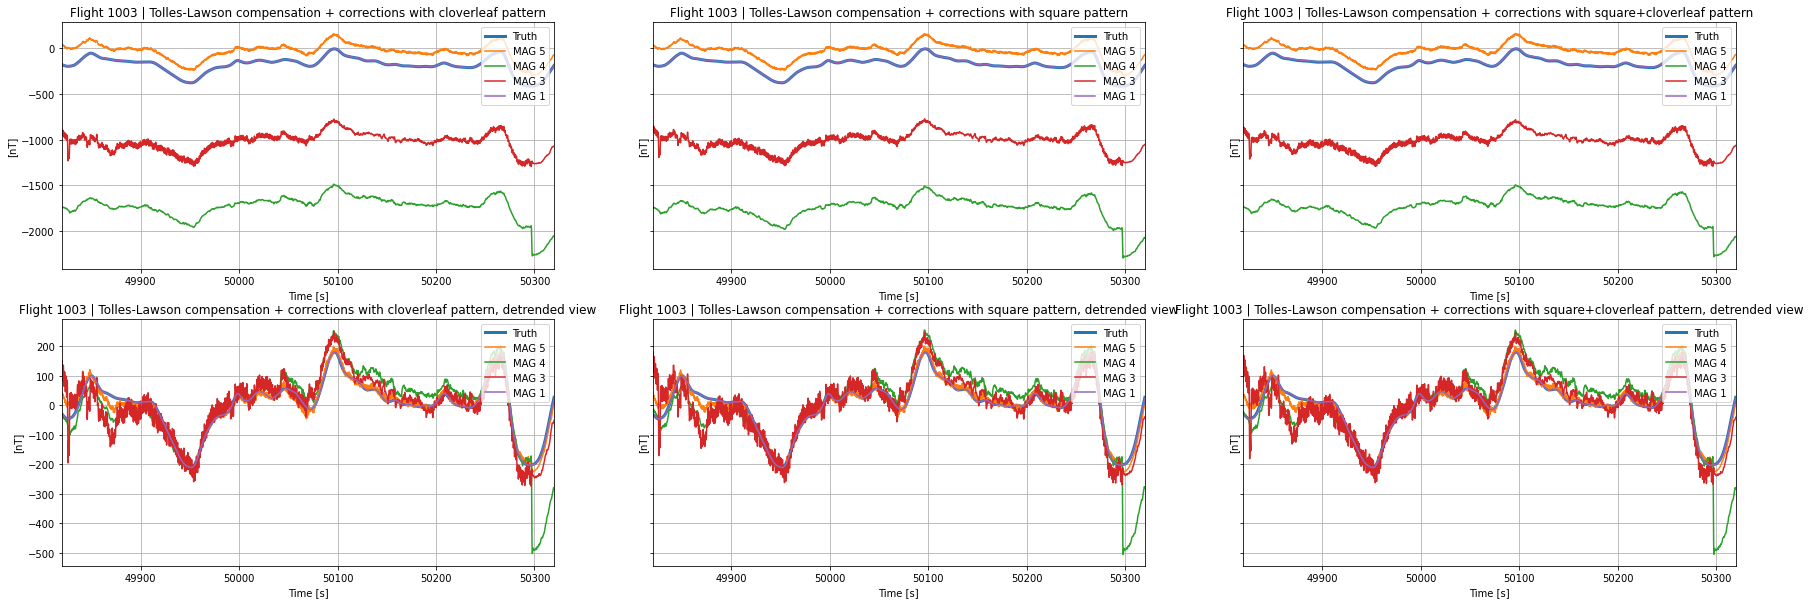

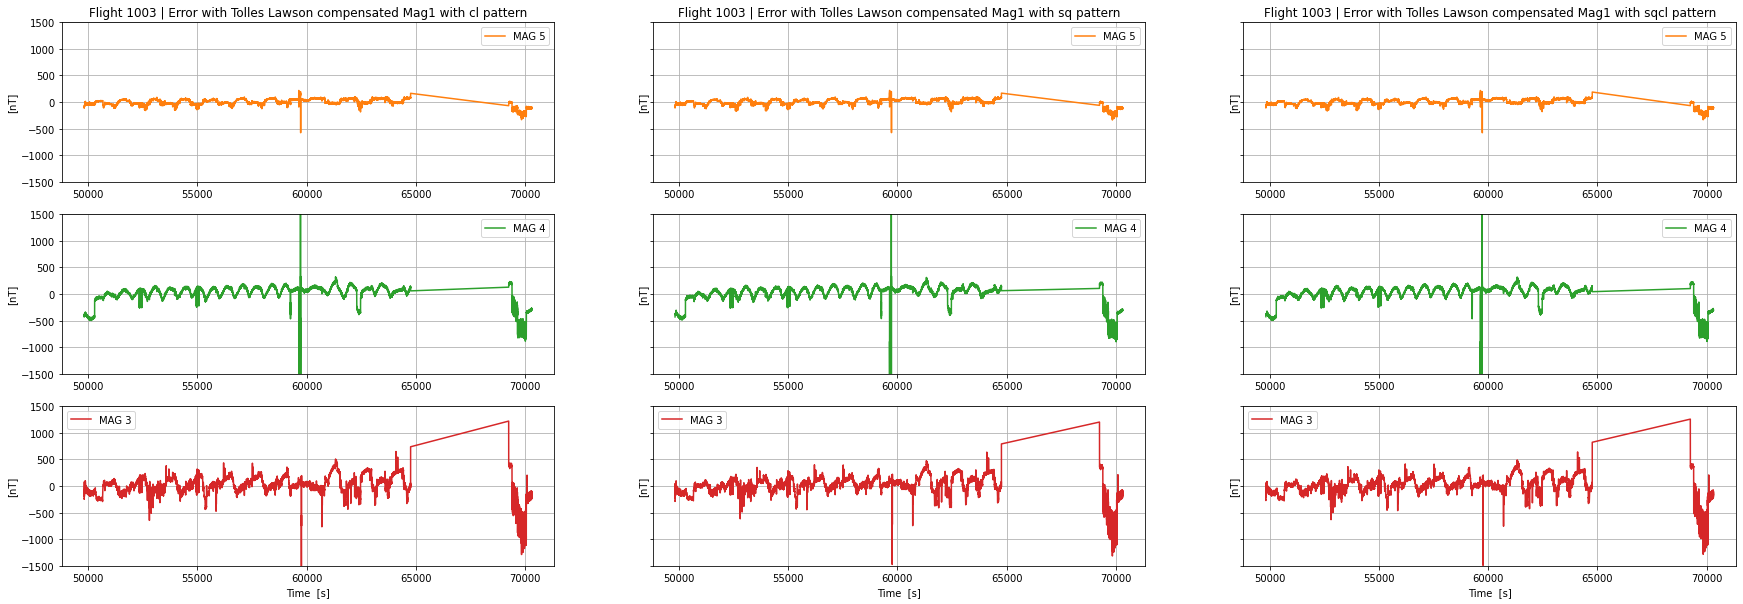


RMSE between Tolles Lowson compensated and corrected magnetometers and truth (SGL IGRFMAG1) :
╒════════════════╤════════════════════════════════════╤════════════════════════════════╤═══════════════════════════════════════════╕
│   Magnetometer │   Cloverleaf compensation RMSE[nT] │   Square compensation RMSE[nT] │   Cloverleaf+Square compensation RMSE[nT] │
╞════════════════╪════════════════════════════════════╪════════════════════════════════╪═══════════════════════════════════════════╡
│          Mag 1 │                            2.33 nT │                        2.33 nT │                                   2.92 nT │
├────────────────┼────────────────────────────────────┼────────────────────────────────┼───────────────────────────────────────────┤
│          Mag 2 │                        18960.53 nT │                    12006.32 nT │                               15421.96 nT │
├────────────────┼────────────────────────────────────┼────────────────────────────────┼───────────────────

In [24]:
fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize=[30,10],sharey='row')

# Cloverleaf pattern
ax1.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_cl'][:COR_df.index[0]+499.9],label='MAG 5')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_cl'][:COR_df.index[0]+499.9],label='MAG 4')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_cl'][:COR_df.index[0]+499.9],label='MAG 3')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_cl'][:COR_df.index[0]+499.9],label='MAG 1')

ax1.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_cl'][:COR_df.index[0]+499.9]),label='MAG 5')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_cl'][:COR_df.index[0]+499.9]),label='MAG 4')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_cl'][:COR_df.index[0]+499.9]),label='MAG 3')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_cl'][:COR_df.index[0]+499.9]),label='MAG 1')

ax4.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('[nT]')
ax4.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with cloverleaf pattern, detrended view')
ax4.legend(loc='upper right')
ax4.grid()

# Square pattern
ax2.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_sq'][:COR_df.index[0]+499.9],label='MAG 5')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_sq'][:COR_df.index[0]+499.9],label='MAG 4')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_sq'][:COR_df.index[0]+499.9],label='MAG 3')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_sq'][:COR_df.index[0]+499.9],label='MAG 1')

ax2.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_sq'][:COR_df.index[0]+499.9]),label='MAG 5')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_sq'][:COR_df.index[0]+499.9]),label='MAG 4')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_sq'][:COR_df.index[0]+499.9]),label='MAG 3')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_sq'][:COR_df.index[0]+499.9]),label='MAG 1')

ax5.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('[nT]')
ax5.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square pattern, detrended view')
ax5.legend(loc='upper right')
ax5.grid()

# Square+Cloverleaf pattern
ax3.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_sqcl'][:COR_df.index[0]+499.9],label='MAG 5')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_sqcl'][:COR_df.index[0]+499.9],label='MAG 4')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_sqcl'][:COR_df.index[0]+499.9],label='MAG 3')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_sqcl'][:COR_df.index[0]+499.9],label='MAG 1')

ax3.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_sqcl'][:COR_df.index[0]+499.9]),label='MAG 5')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_sqcl'][:COR_df.index[0]+499.9]),label='MAG 4')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_sqcl'][:COR_df.index[0]+499.9]),label='MAG 3')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_sqcl'][:COR_df.index[0]+499.9]),label='MAG 1')

ax6.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('[nT]')
ax6.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square+cloverleaf pattern, detrended view')
ax6.legend(loc='upper right')
ax6.grid()

plt.show()

fig, ([ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]) = plt.subplots(3,3,figsize=[30,10],sharey=True)

ax1.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_cl'])),'C1',label='MAG 5')
ax4.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_cl'])),'C2',label='MAG 4')
ax7.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_cl'])),'C3',label='MAG 3')

ax2.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sq'])),'C1',label='MAG 5')
ax5.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sq'])),'C2',label='MAG 4')
ax8.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sq'])),'C3',label='MAG 3')

ax3.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sqcl'])),'C1',label='MAG 5')
ax6.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sqcl'])),'C2',label='MAG 4')
ax9.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sqcl'])),'C3',label='MAG 3')

ax1.set_ylim([-1500,1500])
ax1.grid(),ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid(),ax6.grid(),ax7.grid(),ax8.grid(),ax9.grid()
ax1.legend(),ax2.legend(),ax3.legend(),ax4.legend(),ax5.legend(),ax6.legend(),ax7.legend(),ax8.legend(),ax9.legend()
ax7.set_xlabel('Time  [s]'),ax8.set_xlabel('Time  [s]'),ax9.set_xlabel('Time  [s]')
ax1.set_ylabel('[nT]'),ax2.set_ylabel('[nT]'),ax3.set_ylabel('[nT]'),ax4.set_ylabel('[nT]'),ax5.set_ylabel('[nT]'),ax6.set_ylabel('[nT]'),ax7.set_ylabel('[nT]'),ax8.set_ylabel('[nT]'),ax9.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with cl pattern')
ax2.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sq pattern')
ax3.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sqcl pattern')
plt.show()

RMSE_mag1_sq = magnav.rmse(COR_df['TL_comp_mag1_sq'],COR_df['IGRFMAG1'])
RMSE_mag2_sq = magnav.rmse(COR_df['TL_comp_mag2_sq'],COR_df['IGRFMAG1'])
RMSE_mag3_sq = magnav.rmse(COR_df['TL_comp_mag3_sq'],COR_df['IGRFMAG1'])
RMSE_mag4_sq = magnav.rmse(COR_df['TL_comp_mag4_sq'],COR_df['IGRFMAG1'])
RMSE_mag5_sq = magnav.rmse(COR_df['TL_comp_mag5_sq'],COR_df['IGRFMAG1'])

RMSE_mag1_cl = magnav.rmse(COR_df['TL_comp_mag1_cl'],COR_df['IGRFMAG1'])
RMSE_mag2_cl = magnav.rmse(COR_df['TL_comp_mag2_cl'],COR_df['IGRFMAG1'])
RMSE_mag3_cl = magnav.rmse(COR_df['TL_comp_mag3_cl'],COR_df['IGRFMAG1'])
RMSE_mag4_cl = magnav.rmse(COR_df['TL_comp_mag4_cl'],COR_df['IGRFMAG1'])
RMSE_mag5_cl = magnav.rmse(COR_df['TL_comp_mag5_cl'],COR_df['IGRFMAG1'])

RMSE_mag1_sqcl = magnav.rmse(COR_df['TL_comp_mag1_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag2_sqcl = magnav.rmse(COR_df['TL_comp_mag2_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag3_sqcl = magnav.rmse(COR_df['TL_comp_mag3_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag4_sqcl = magnav.rmse(COR_df['TL_comp_mag4_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag5_sqcl = magnav.rmse(COR_df['TL_comp_mag5_sqcl'],COR_df['IGRFMAG1'])

table = [['Magnetometer','Cloverleaf compensation RMSE[nT]','Square compensation RMSE[nT]','Cloverleaf+Square compensation RMSE[nT]'],
         ['Mag 1',f'{RMSE_mag1_cl:.2f} nT',f'{RMSE_mag1_sq:.2f} nT',f'{RMSE_mag1_sqcl:.2f} nT'],
         ['Mag 2',f'{RMSE_mag2_cl:.2f} nT',f'{RMSE_mag2_sq:.2f} nT',f'{RMSE_mag2_sqcl:.2f} nT'],
         ['Mag 3',f'{RMSE_mag3_cl:.2f} nT',f'{RMSE_mag3_sq:.2f} nT',f'{RMSE_mag3_sqcl:.2f} nT'],
         ['Mag 4',f'{RMSE_mag4_cl:.2f} nT',f'{RMSE_mag4_sq:.2f} nT',f'{RMSE_mag4_sqcl:.2f} nT'],
         ['Mag 5',f'{RMSE_mag5_cl:.2f} nT',f'{RMSE_mag5_sq:.2f} nT',f'{RMSE_mag5_sqcl:.2f} nT']]

print('\nRMSE between Tolles Lowson compensated and corrected magnetometers and truth (SGL IGRFMAG1) :')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='right'))

<font size="4">Interpretation of results :</font><br>
We can see that the RMSEs of the Tolles Lawson compensation and Tolles Lawson compensation + corrections are identical. This is due to the fact that the corrections are mainly constants. We can see that on the detrended view and the RMSE that the magnetometer 5 is close to the magnetometer 1. Magnetometers 3 and 4 follow the closetrend on magnetometer 1 but their RMSE is more significant with larger deviations. [Same conclusion](#explication) than before for the error between the truth and the magnetometers.